In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# spotify-2023.csv from https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023
csv_input = "spotify-2023.csv"
csv_categoric = "spotify-2023-categoric.csv"
csv_numeric = "spotify-2023-numeric.csv"

df = pd.read_csv(csv_input, encoding="ISO-8859-1")
pd.set_option('display.max_columns', None)

print(df.isnull().sum())
print(df.dtypes)
df

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64
track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int6

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,13,37,1,0,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,0,8,0,0,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,0,7,0,0,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,26,17,0,0,97,C#,Major,82,67,77,8,0,12,5


# **Data cleaning and preprocessing**

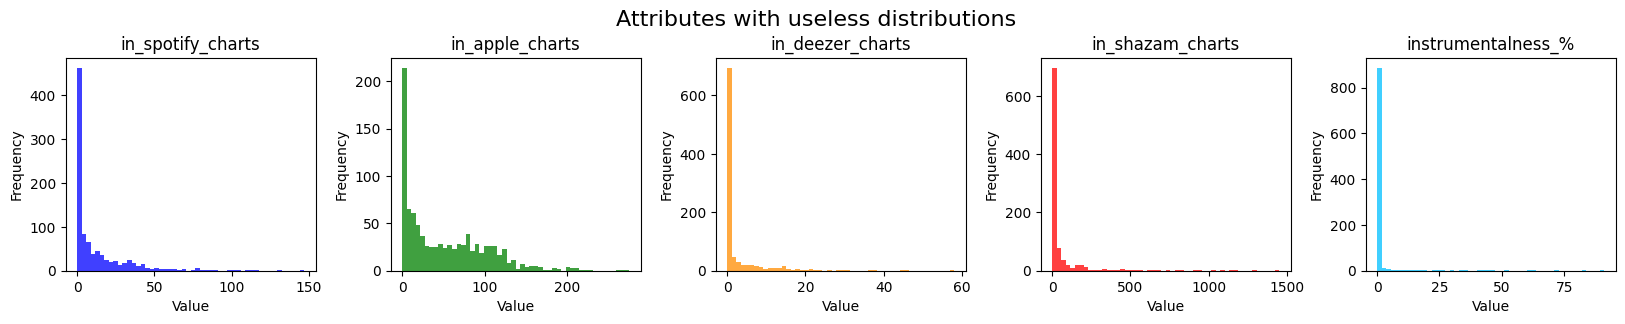

In [3]:
df2 = df.copy(deep=True)
df2['streams'] = pd.to_numeric(df2['streams'], errors='coerce')
df2 = df2.loc[~df2['streams'].isna()]
df2['streams'] = df2['streams'].astype(int)

# fix thousand separator
df2['in_deezer_playlists'] = df2['in_deezer_playlists'].map(lambda x: x.replace(',', ''))
df2['in_deezer_playlists'] = pd.to_numeric(df2['in_deezer_playlists']).astype(int)

# fix thousand separator
df2['in_shazam_charts'] = df2['in_shazam_charts'].str.replace(',', '')
df2['in_shazam_charts'] = df2['in_shazam_charts'].fillna(0).astype(int)

df2['key'] = df2['key'].fillna('C').astype('category')
df2['mode'] = df2['mode'].astype('category')

# Columns with useless data distribution
colors = ['blue', 'green', 'darkorange', 'red', 'deepskyblue']
cols = ['in_spotify_charts', 'in_apple_charts', 'in_deezer_charts',
        'in_shazam_charts', 'instrumentalness_%']
fig, axs = plt.subplots(1, len(cols), figsize=(len(cols) * 4, 3))
for i, col in enumerate(cols):
    axs[i].hist(df2[col], bins=50, color=colors[i], alpha=0.75)
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
plt.suptitle("Attributes with useless distributions", fontsize=16)
plt.subplots_adjust(top=0.82)
plt.subplots_adjust(wspace=0.3)
plt.show()

# Useless attributes and other irelevant columns to be dropped
cols_to_drop = [
    'track_name',
    'artist_count',
    'released_month',
    'released_day',
    'in_spotify_charts',
    'in_apple_charts',
    'in_deezer_charts',
    'in_shazam_charts',
    'instrumentalness_%',
    'liveness_%',
]

# Drop irelevant columns
for col in cols_to_drop:
    if col in df2.columns:
        df2.drop(col, axis=1, inplace=True)

# --------------------------------------

df_orig = df2.copy()

# **Discretization of numerical attributes**


In [4]:
# Transform to intervals 0-step%, ...
def perc_to_ctg(df, orig_col, new_col, step=5):
    """
    Divide to categorical bins of step sizes and rename to <left>-<right>%
    (e.g. 0-4%, 5-9% for step=5)
    """
    # <0-101) the rightmost integer will be excluded => <0-100>
    bins = list(np.arange(0, 101-step, step)) + [101]
    bin_labels = [f"{l}-{r-1}%" for l, r in zip(bins[:-1], bins[1:])]

    df.loc[:, new_col] = pd.cut(df[orig_col], bins, right=False,
                         labels=bin_labels).astype('category')


# Transform to intervals 0-(max_val/max_n)%, ...
def section_to_ctg(df, orig_col, new_col, max_n=5, mode=''):
    """
    Divide to maximally 'max_n' equal sections (except the last one)
    """
    max_val = df.loc[:, orig_col].max()
    bins = list(np.arange(0, df.loc[:, orig_col].max(), int(max_val / max_n)))
    bins[-1] = max_val+1

    bin_labels = [f"{l}-{r-1}%" for l, r in zip(bins[:-1], bins[1:])]

    df.loc[:, new_col] = pd.cut(df[orig_col], bins, right=False,
                         labels=bin_labels).astype('category')


# Transform to "less-than" intervals <50.00M%, ... (default)
def step_to_ctg(df, orig_col, new_col, step=50_000_000):
    """
    Divide unknown data to unspecified number of classes using the implicit step
    and use the shortcut format of labels ('<950.00M', '<1.00B', ...)
    """
    # Difference from billion 10^9 to be able to differ intervals
    digits = 9 - int(np.log10(step))
    max_val = df.loc[:, orig_col].max()
    bins = list(np.arange(0, df.loc[:, orig_col].max() + step, step))
    # Shortcuts for thousand, million and billion
    letter = ['k', 'M', 'B']

    bin_labels = ["<{:.{}f}{}".format(
        r / (10**(int(np.log10(r))-(int(np.log10(r)) % 3))), digits,
        letter[int(np.log10(r) / 3) - 1]) for l, r in zip(bins[:-1], bins[1:])]

    df.loc[:, new_col] = pd.cut(df.loc[:, orig_col], bins, right=False,
                         labels=bin_labels).astype('category')


# Transform to quantile intervals 0-X[%], ...
# (number of samples are equal: cnt|0-X|==cnt|X-Y|==...)
def quantile_to_ctg(df, orig_col, new_col, qn=10, sfix="", mode=''):
    """
    Divide to qn quantiles with almost the same number of elements and rename to
    <left>-<right>[sfix] interval categories (e.g. 27-35%)
    """
    q_unique_ctgs = pd.qcut(df.loc[:, orig_col], q=qn,
                            duplicates='drop').unique().tolist()
    q_unique_ctgs.sort()

    q_labels = [f"{int(c.left)+(1 if c.left > 0 else 0)}-{int(c.right)}{sfix}"
                for c in q_unique_ctgs]

    df.loc[:, new_col] = pd.qcut(df.loc[:, orig_col], q=qn, duplicates='drop',
                          labels=q_labels).astype('category')


In [5]:
# ------ Divide by steps ------
# valence_%: Positivity of the song's musical content
perc_to_ctg(df2, 'valence_%', 'valence_%_ctg', 5)

# danceability_%: Percentage indicating how suitable the song is for dancing
perc_to_ctg(df2, 'danceability_%', 'danceability_%_ctg', 10)

# energy_%: Perceived energy level of the song
perc_to_ctg(df2, 'energy_%', 'energy_%_ctg', 5)

# streams: Total number of streams on Spotify
step_to_ctg(df2, 'streams', 'streams_%_ctg', 50_000_000)

# Max number of groups instead of a specific step
# speechiness_%: Amount of spoken words in the song
section_to_ctg(df2, 'speechiness_%', 'speechiness_%_ctg', 15)


# ---- Divide to quantiles ----
# acousticness_%: Amount of acoustic sound in the song
quantile_to_ctg(df2, 'acousticness_%', 'acousticness_%_ctg', 10, "%")

# bpm: Beats per minute, a measure of song tempo
quantile_to_ctg(df2, 'bpm', 'bpm_ctg', 10)

df2.head(10)

,artist(s)_name,released_year,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,speechiness_%,valence_%_ctg,danceability_%_ctg,energy_%_ctg,streams_%_ctg,speechiness_%_ctg,acousticness_%_ctg,bpm_ctg
0,"Latto, Jung Kook",2023,553,141381703,43,45,125,B,Major,80,89,83,31,4,85-89%,80-89%,80-84%,<150.00M,4-7%,27-37%,122-128
1,Myke Towers,2023,1474,133716286,48,58,92,C#,Major,71,61,74,7,4,60-64%,70-79%,70-74%,<150.00M,4-7%,5-7%,90-95
2,Olivia Rodrigo,2023,1397,140003974,94,91,138,F,Major,51,32,53,17,6,30-34%,50-59%,50-54%,<150.00M,4-7%,13-18%,138-145
3,Taylor Swift,2019,7858,800840817,116,125,170,A,Major,55,58,72,11,15,55-59%,50-59%,70-74%,<850.00M,12-15%,8-12%,165-206
4,Bad Bunny,2023,3133,303236322,84,87,144,A,Minor,65,23,80,14,6,20-24%,60-69%,80-84%,<350.00M,4-7%,13-18%,138-145
5,"Dave, Central Cee",2023,2186,183706234,67,88,141,C#,Major,92,66,58,19,24,65-69%,90-100%,55-59%,<200.00M,24-27%,19-26%,138-145
6,"Eslabon Armado, Peso Pluma",2023,3090,725980112,34,43,148,F,Minor,67,83,76,48,3,80-84%,60-69%,75-79%,<750.00M,0-3%,38-50%,146-164
7,Quevedo,2023,714,58149378,25,30,100,F,Major,67,26,71,37,4,25-29%,60-69%,70-74%,<100.00M,4-7%,27-37%,96-104
8,Gunna,2023,1096,95217315,60,48,130,C#,Minor,85,22,62,12,9,20-24%,80-89%,60-64%,<100.00M,8-11%,8-12%,129-137
9,"Peso Pluma, Yng Lvcas",2023,2953,553634067,49,66,170,D,Minor,81,56,48,21,33,55-59%,80-89%,45-49%,<600.00M,32-35%,19-26%,165-206


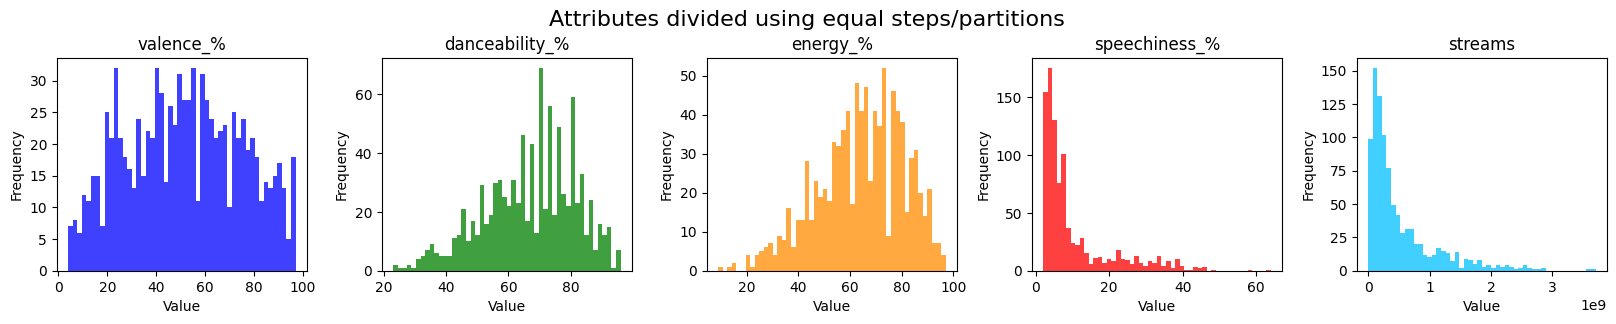

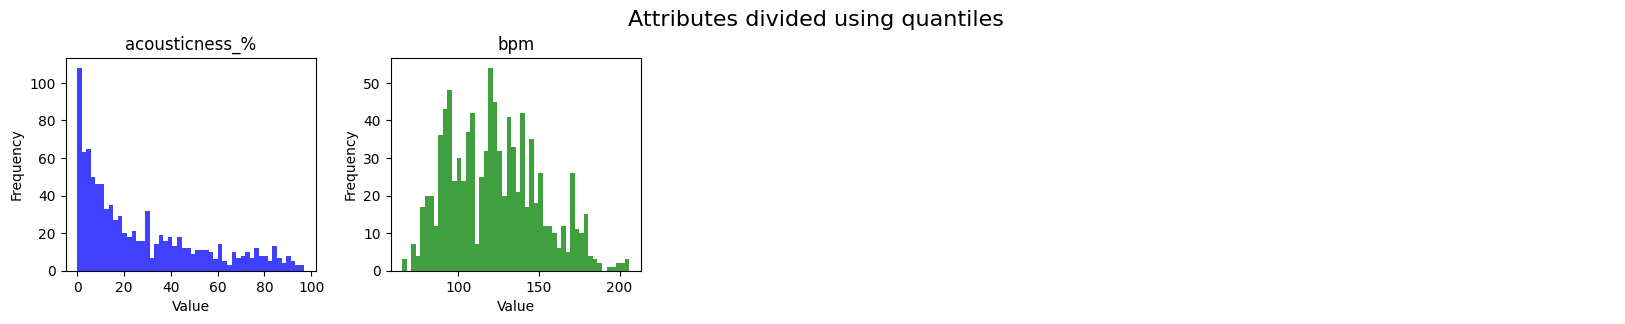

In [6]:
colors = ['blue', 'green', 'darkorange', 'red', 'deepskyblue']

cols = ['valence_%', 'danceability_%', 'energy_%', 'speechiness_%', 'streams']
fig, axs = plt.subplots(1, len(cols), figsize=(len(cols) * 4, 3))
for i, col in enumerate(cols):
    axs[i].hist(df2[col], bins=50, color=colors[i], alpha=0.75)
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
plt.suptitle("Attributes divided using equal steps/partitions", fontsize=16)
plt.subplots_adjust(top=0.82)
plt.subplots_adjust(wspace=0.3)
plt.show()


cols = ['acousticness_%', 'bpm']
fig, axs = plt.subplots(1, len(cols) + 3, figsize=(len(cols) * 4 + 12, 3))
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
for i, col in enumerate(cols):
    axs[i].hist(df2[col], bins=50, color=colors[i], alpha=0.75)
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
plt.suptitle("Attributes divided using quantiles", fontsize=16)
plt.subplots_adjust(top=0.82)
plt.subplots_adjust(wspace=0.3)
plt.show()

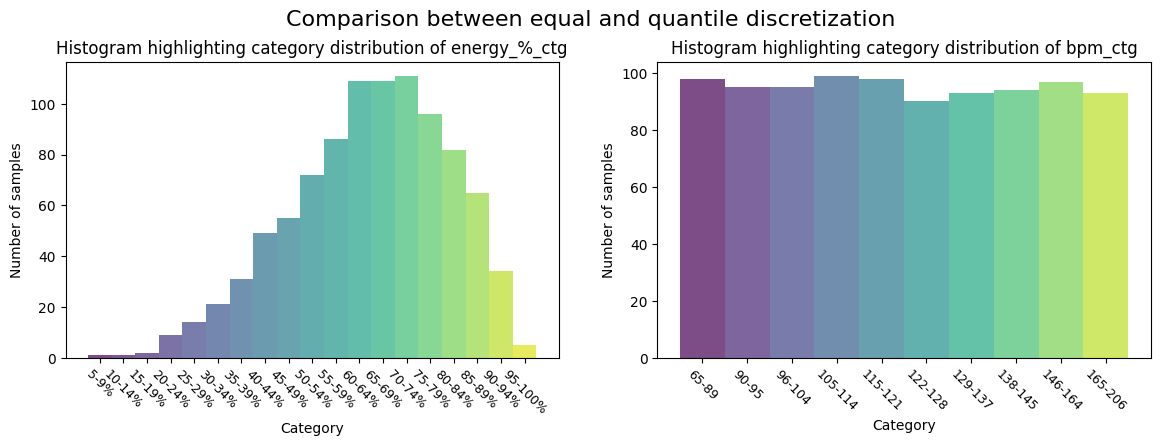

In [7]:
def plot_ctg_histogram(cname_list):
    """
    Plot a histogram of samples in each category for columns in cname_list
    """
    fig, axes = plt.subplots(1, len(cname_list),
                             figsize=(len(cname_list) * 7, 4))

    for idx, cname in enumerate(cname_list):
        # Select dataframe column
        data = df2[cname]
        # Categories orderd ascendingly
        ctgs = sorted(df2[cname].unique(),
                      key=(lambda s: int(s.split('-')[0])))
        # Colors according to number of categories
        colors = [cm.viridis(i / len(ctgs)) for i in range(len(ctgs))]

        # Plot a histogram column for each category
        for i, ctg in enumerate(ctgs):
            axes[idx].hist(data[data == ctg], bins=1, color=colors[i],
                    alpha=0.7, label=ctg, width=1, align='mid')

        axes[idx].set_xlabel("Category")
        axes[idx].set_ylabel("Number of samples")
        axes[idx].set_title(f"Histogram highlighting "
                            f"category distribution of {cname}")
        axes[idx].tick_params(axis='x', which='major',
                              labelsize=9, rotation=-45)
        # axes[idx].legend()

    fig.suptitle('Comparison between equal and quantile discretization',
                 fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()


plot_ctg_histogram(['energy_%_ctg', 'bpm_ctg'])


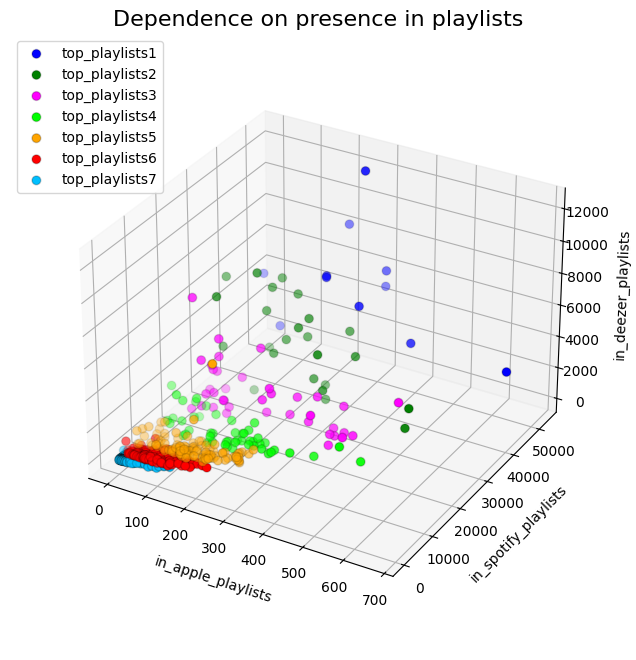

In [8]:
# Columns to be clustered
# in_<x>_playlists: Number of <x> playlists the song is included in
cols = ['in_apple_playlists', 'in_spotify_playlists', 'in_deezer_playlists']
# Number of clusters
k = 7
# Cluster colors
colors = ['blue', 'green', 'magenta', 'lime', 'orange', 'red', 'deepskyblue']

# Data for clustering
data = pd.DataFrame(df2.copy(), columns=cols)
data['total'] = data.iloc[:, 0:3].sum(axis=1)

# Kmeans clustering to group by top songs in playlists
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a new column and assign cluster labels
data['top_playlists'] = labels
# Group by mean number of occurrence in playlists
groups = data.groupby('top_playlists').agg({'total': 'mean'}).reset_index()
# Order by most -> least
groups = groups.sort_values(by='total', ascending=False)

# Value at indexes[c] where c is the cluster number will be the new label
indexes = [0] * k
for i, c in enumerate(groups['top_playlists']):
    indexes[c] = f"top_playlists{i+1}"
labels = [indexes[i] for i in labels]

# Finally assign cluster labels to dataframes
data['top_playlists'] = labels
df2['top_playlists'] = labels


# 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.88)

for i in range(k):
    # Order top_playlists<C> by ascending <C> number
    sorted_i = sorted(indexes)
    k_data = data[data['top_playlists'] == sorted_i[i]]
    ax.scatter(k_data[cols[0]], k_data[cols[1]], k_data[cols[2]],
               c=[colors[i] for a in range(k_data[cols[0]].size)],
               label=sorted_i[i], s=40, edgecolors='#00000035')

ax.set_title('Dependence on presence in playlists', fontsize=16)
ax.set_xlabel(cols[0], labelpad=10)
ax.set_ylabel(cols[1], labelpad=10)
ax.set_zlabel(cols[2], labelpad=10)

plt.legend(loc='upper left')
plt.show()

# Save `CSV` with categoric attributes

In [9]:
# Drop transformed columns
cols_to_drop = [
    'in_spotify_playlists', # Clustered
    'streams',              # Categorized
    'in_apple_playlists',   # Clustered
    'in_deezer_playlists',  # Clustered
    'bpm',                  # Categorized using quantiles
    'danceability_%',       # Categorized
    'valence_%',            # Categorized
    'energy_%',             # Categorized
    'acousticness_%',       # Categorized using quantiles
    'speechiness_%'         # Categorized
]

# Drop columns
for col in cols_to_drop:
    if col in df2.columns:
        df2.drop(col, axis=1, inplace=True)

# Convert to category types
for col in df2.columns:
    df2[col] = df2[col].astype('category')

print(df2.dtypes)

df2 = df2.reset_index(drop=True)
df2.head(50).to_csv(csv_categoric, index=False)

df2

artist(s)_name        category
released_year         category
key                   category
mode                  category
valence_%_ctg         category
danceability_%_ctg    category
energy_%_ctg          category
streams_%_ctg         category
speechiness_%_ctg     category
acousticness_%_ctg    category
bpm_ctg               category
top_playlists         category
dtype: object


,artist(s)_name,released_year,key,mode,valence_%_ctg,danceability_%_ctg,energy_%_ctg,streams_%_ctg,speechiness_%_ctg,acousticness_%_ctg,bpm_ctg,top_playlists
0,"Latto, Jung Kook",2023,B,Major,85-89%,80-89%,80-84%,<150.00M,4-7%,27-37%,122-128,top_playlists7
1,Myke Towers,2023,C#,Major,60-64%,70-79%,70-74%,<150.00M,4-7%,5-7%,90-95,top_playlists7
2,Olivia Rodrigo,2023,F,Major,30-34%,50-59%,50-54%,<150.00M,4-7%,13-18%,138-145,top_playlists7
3,Taylor Swift,2019,A,Major,55-59%,50-59%,70-74%,<850.00M,12-15%,8-12%,165-206,top_playlists5
4,Bad Bunny,2023,A,Minor,20-24%,60-69%,80-84%,<350.00M,4-7%,13-18%,138-145,top_playlists6
...,...,...,...,...,...,...,...,...,...,...,...,...
947,Selena Gomez,2022,A,Major,20-24%,60-69%,35-39%,<100.00M,0-3%,51-71%,138-145,top_playlists7
948,Taylor Swift,2022,F#,Major,5-9%,40-49%,20-24%,<150.00M,4-7%,72-97%,165-206,top_playlists7
949,"Feid, Paulo Londra",2022,C#,Major,80-84%,80-89%,65-69%,<100.00M,4-7%,2-4%,90-95,top_playlists7
950,"Feid, Sech, Jhayco",2022,C#,Major,65-69%,80-89%,75-79%,<150.00M,4-7%,8-12%,96-104,top_playlists7


# **Categorical to numeric attributes conversion**

In [10]:
# Reload the original dataframe
df = df_orig

In [11]:
# Convert artist(s)_name to numeric artist(s)_name_num
df['artist(s)_name'] = df['artist(s)_name'].astype('category')
df['artist(s)_name_num'] = df['artist(s)_name'].cat.codes.astype(int)

# Convert mode (major or minor) to numeric mode_num
df['mode'] = df['mode'].astype('category')
df['mode_num'] = df['mode'].cat.codes.astype(int)

In [12]:
# Convert key to numeric key_num
def sort_keys(note):
    """
    Sorting function to order notes in the correct melody order
    """
    # Possible keys
    k_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    # Main tone
    note_main = note[0] if len(note) > 1 else note
    # Nothing or '#'
    note_half = note[1] if len(note) > 1 else ''
    return (k_order.index(note_main), note_half)

# Ordered keys
sorted_keys = sorted(df['key'].unique(), key=sort_keys)
dict_keys = {key: i for i, key in enumerate(sorted_keys)}

# Get the proper values according to assigned numbers to keys
df['key_num'] = ([dict_keys[key] for key in df['key']])
df['key_num'] = df['key_num'].astype(int)

In [13]:
# Aggregate in_spotify/apple/deezer_playlists to a single column
df['in_playlists'] = df['in_spotify_playlists']\
                   + df['in_apple_playlists']\
                   + df['in_deezer_playlists']

# Normalization

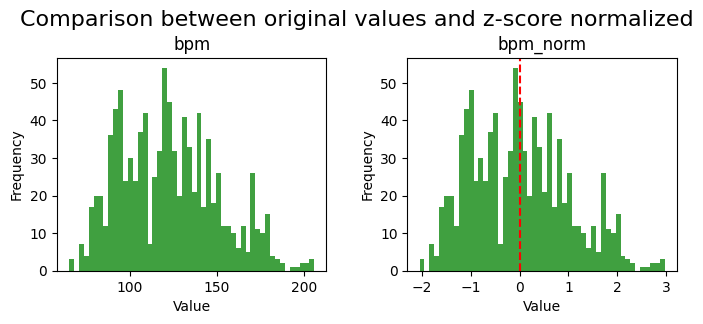

,artist(s)_name,released_year,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,speechiness_%,artist(s)_name_num,mode_num,key_num,in_playlists,streams_norm,bpm_norm
0,"Latto, Jung Kook",2023,553,141381703,43,45,125,B,Major,80,89,83,31,4,325,0,11,641,0.141382,0.087156
1,Myke Towers,2023,1474,133716286,48,58,92,C#,Major,71,61,74,7,4,400,0,1,1580,0.133716,-1.088493
2,Olivia Rodrigo,2023,1397,140003974,94,91,138,F,Major,51,32,53,17,6,430,0,5,1582,0.140004,0.550290
3,Taylor Swift,2019,7858,800840817,116,125,170,A,Major,55,58,72,11,15,557,0,9,8099,0.800841,1.690314
4,Bad Bunny,2023,3133,303236322,84,87,144,A,Minor,65,23,80,14,6,43,1,9,3304,0.303236,0.764045


In [14]:
# Normalize streams to streams_norm by changing the decadic scale
# Set the range to billions (streams_norm are float billions)
top_val = 1e9 # 1B
df['streams_norm'] = round(df['streams'] / top_val, 8)


# Normalize bpm to bpm_norm using z-score normalization
mean = df['bpm'].mean()
std = df['bpm'].std()
df['bpm_norm'] = round((df['bpm'] - mean) / std, 8)

# Visualize the difference between bpm and bpm_norm
# bpm_norm shows the distribution around a normal (mean) value
cols = ['bpm', 'bpm_norm']
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
for i, col in enumerate(cols):
    axs[i].hist(df[col], bins=50, color='green', alpha=0.75)
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

    if(col == 'bpm_norm'):
        plt.axvline(x=0, color='r', linestyle='dashed')

plt.suptitle("Comparison between original values and z-score normalized",
             fontsize=16)
plt.subplots_adjust(top=0.82)
plt.subplots_adjust(wspace=0.3)
plt.show()

df.head(5)

# Save `CSV` with numeric attributes

In [15]:
# Drop transformed columns
cols_to_drop = [
    'in_spotify_playlists', # Aggregated
    'streams',              # Normalized
    'in_apple_playlists',   # Aggregated
    'in_deezer_playlists',  # Aggregated
    'bpm',                  # Normalized
    'artist(s)_name',       # Encoded
    'key',                  # Encoded
    'mode'                  # Encoded to 2 classes
]

# Drop columns
for col in cols_to_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Convert to category types
for col in df.columns:
    if(col in ['streams_norm', 'bpm_norm']):
        df[col] = df[col].astype(float)
    else:
        df[col] = df[col].astype(int)

print(df.dtypes)

df = df.reset_index(drop=True)
df.head(50).to_csv(csv_numeric, index=False)

df

released_year           int64
danceability_%          int64
valence_%               int64
energy_%                int64
acousticness_%          int64
speechiness_%           int64
artist(s)_name_num      int64
mode_num                int64
key_num                 int64
in_playlists            int64
streams_norm          float64
bpm_norm              float64
dtype: object


,released_year,danceability_%,valence_%,energy_%,acousticness_%,speechiness_%,artist(s)_name_num,mode_num,key_num,in_playlists,streams_norm,bpm_norm
0,2023,80,89,83,31,4,325,0,11,641,0.141382,0.087156
1,2023,71,61,74,7,4,400,0,1,1580,0.133716,-1.088493
2,2023,51,32,53,17,6,430,0,5,1582,0.140004,0.550290
3,2019,55,58,72,11,15,557,0,9,8099,0.800841,1.690314
4,2023,65,23,80,14,6,43,1,9,3304,0.303236,0.764045
...,...,...,...,...,...,...,...,...,...,...,...,...
947,2022,60,24,39,57,3,516,0,9,1051,0.091473,0.764045
948,2022,42,7,24,83,6,557,0,6,1192,0.121872,1.547811
949,2022,80,81,67,4,6,183,0,1,582,0.073514,-1.088493
950,2022,82,67,77,8,5,184,0,1,1366,0.133896,-0.910365
